In [1]:
# check the current environment
using Pkg; Pkg.status()

Status `~/Documents/tutorial-tensornetwork/examples/circuit_simulation/Project.toml`
  [ebe7aa44] OMEinsum v0.9.1
  [5872b779] Yao v0.9.2 `~/.julia/dev/Yao`


## Circuit loading
The circuits are placed under the `data` folder, check the available circuit with:

In [2]:
using Yao

# circuit reader
include("reader.jl")
using .YaoQASMReader: yaocircuit_from_qasm

In [3]:
readdir("data")

5-element Vector{String}:
 "README.md"
 "circuits"
 "grid"
 "ordering"
 "patterns"

We load the Sycamore 8 layer circuit data to Julia with [Yao](https://github.com/QuantumBFS/Yao.jl) (幺), a high performance quantum simulator. Sycamore circuit is a famous circuit that used in the random circuit benchmarking experiment to showcase the quantum advantage.

**Reference**: Arute, et al, 2019. Quantum supremacy using a programmable superconducting processor. Nature 574, 505–510. https://doi.org/10.1038/s41586-019-1666-5

In [6]:
filename = joinpath(@__DIR__, "data", "circuits", "test.txt")

"/home/leo/Documents/tutorial-tensornetwork/examples/circuit_simulation/data/circuits/test.txt"

┌ Info: Circuit: /home/leo/Documents/tutorial-tensornetwork/examples/circuit_simulation/data/circuits/test.txt
└ @ Main /home/leo/Documents/tutorial-tensornetwork/examples/circuit_simulation/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W6sZmlsZQ==.jl:2


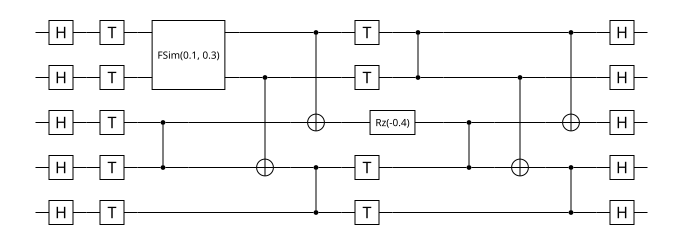

In [7]:
# load a visualize
@info "Circuit: $(filename)"
c = yaocircuit_from_qasm(filename)
vizcircuit(c)

## Case 1: compute <0|c|0> with tensor networks

During the convertion, we also specify an optimizer to specify the contraction order.

In [8]:
initial_state = Dict(zip(1:nqubits(c), zeros(Int,nqubits(c))))
final_state = Dict(zip(1:nqubits(c), zeros(Int,nqubits(c))))
optimizer = TreeSA(ntrials=1)
net = yao2einsum(c; initial_state, final_state, optimizer)
@info "Contraction complexity: $(contraction_complexity(net))"

┌ Info: Contraction complexity: Time complexity: 2^8.507794640198696
│ Space complexity: 2^4.0
│ Read-write complexity: 2^9.38586240064146
└ @ Main /home/leo/Documents/tutorial-tensornetwork/examples/circuit_simulation/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X11sZmlsZQ==.jl:5


The space complexity 2^23 means the largest itermediate tensor is only 23, which costs 2^23 complex number storage. It is a much smaller number compared with the full amplitude simulation that costs 2^53 in storage.

In [9]:
psi0 = contract(net)

0-dimensional Array{ComplexF64, 0}:
-0.04445106150832765 + 0.22238551357722364im

## Case 2: Add noise and compute <ψ|X₁X₂|ψ>, where |ψ> = c |0>

During the convertion, we also specify an optimizer to specify the contraction order.

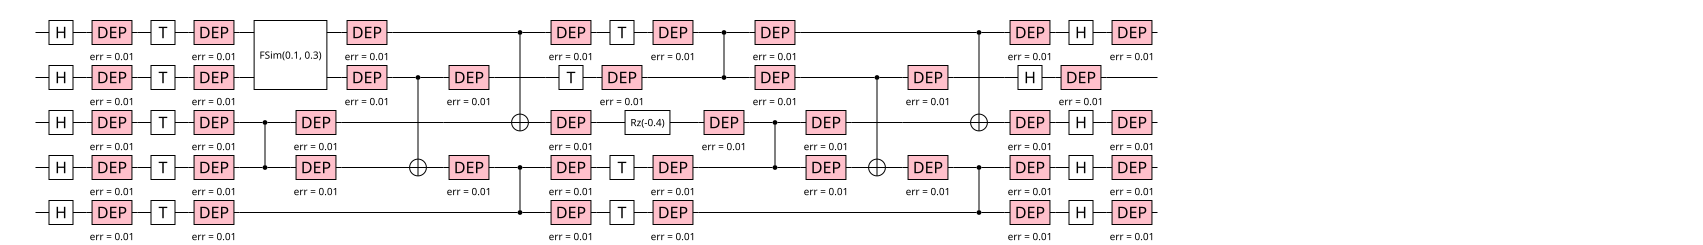

In [12]:
# ## Case 2: add noise and compute <ψ|X₁X₂|ψ>, where |ψ> = c |0>
function add_depolarizing_noise(c::AbstractBlock, depolarizing)
    Optimise.replace_block(c) do blk
        if blk isa PutBlock || blk isa ControlBlock
            rep = chain(blk)
            for loc in occupied_locs(blk)
                push!(rep, put(nqubits(blk), loc=>DepolarizingChannel(1, depolarizing)))
            end
            return rep
        else
            return blk
        end
    end
end
noisy_c = add_depolarizing_noise(c, 0.01)
vizcircuit(noisy_c)


In [11]:
initial_state = Dict(zip(1:nqubits(noisy_c), zeros(Int,nqubits(noisy_c))))
observable = kron(nqubits(noisy_c), 1=>X, 2=>X)
noisy_net = yao2einsum(noisy_c; initial_state, observable, optimizer, mode=DensityMatrixMode())
@info "Contraction complexity: $(contraction_complexity(net))"

┌ Info: Contraction complexity: Time complexity: 2^8.507794640198696
│ Space complexity: 2^4.0
│ Read-write complexity: 2^9.38586240064146
└ @ Main /home/leo/Documents/tutorial-tensornetwork/examples/circuit_simulation/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X16sZmlsZQ==.jl:4


In [ ]:
# contract(noisy_net)